# Creating gymnasium environment

### Importing Packages

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import random as rd
import time

from gym import Env, spaces

### Coor class

In [230]:
class Coor():
    def __init__(self, coor):
        self.x = coor[0]
        self.y = coor[1]

    def get(self):
        return self.x, self.y
    
    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def __add__(self, coor2):
        return Coor((self.x + coor2.x, self.y + coor2.y))
    
    def __eq__(self, coor2):
        if coor2 == None:
            return False
        return (self.x==coor2.x) and (self.y==coor2.y)
    
    def __neg__(self):
        x,y = self.get()
        return Coor((-x,-y))
    
    def __sub__(self, coor2):
        coor = - coor2
        return self + coor
    
    def norm(self):
        x,y = self.get()
        return np.sqrt(x*x + y*y)
    
    def dist(self, coor2):
        return (self -coor2).norm()


### Track class

Contrary to previous environment, track are not matrix anymore.

In [231]:
RED = [255, 0, 0]
GREEN = [0, 255, 0]
BLUE = [0, 0, 255]
GREY = [70 for _ in range(3)]
WHITE = [240 for _ in range(3)]

START_CHAR = 2
END_CHAR = 3
CAR_CHAR = 4

def color(b):
    if b == START_CHAR:
        return GREEN
    elif b == END_CHAR:
        return RED
    elif b == 1:
        return GREY
    else:
        return WHITE
    

class Track():
    def __init__(self, tab):
        #switching height and width for plan approach
        self.width: int = len(tab)
        self.height: int = len((tab[0]))
        self.basic_info_track:list = [[i for i in j] for j in tab]
        
        self.info_track:list = [[None for _ in range(self.height)] for _ in range(self.width)]
        for x in range(self.width):
            for y in range(self.height):
                self.info_track[x][y] = self.basic_info_track[self.height-1-y][x]

        self.color_track = [[color(self.info_track[y][x]) for y in range(self.height)] for x in range(self.width)]

        self.end = None
        self.start = None
        for i in range(self.height):
            for j in range(self.width):
                if self.info_track[i][j] == START_CHAR:
                    self.start = Coor((i,j))
                if self.info_track[i][j] == END_CHAR:
                    self.end = Coor((i,j))

    def get_color(self, coor:Coor):
        """return the color of the case x,y"""
        x,y = coor.get()
        return color(self.info_track[x][y])
    
    def is_wall(self, coor:Coor):
        """Return True if case (x,y) is a wall"""
        x,y = coor.get()
        nx,ny = int(round(x)), int(round(y))
        return (self.info_track[nx][ny] == 1)

    def get_start(self):
        """Return coordinate of start"""
        if self.start == None:
            return None
        return self.start.get()
    
    def get_end(self):
        """Return coordinate of end"""
        return self.end.get()
    
    def is_case_ridable(self, coor: Coor):
        """Return if the car can go on the coordinate or not"""
        x,y = coor.get()
        x,y = int(round(x)), int(round(y))
        if not (x>=0 and x<self.width and y>=0 and y<self.height):
            return False
        return not self.is_wall(coor)

    def plot(self, hide=False):
        """Plot the track using matplotlib"""
        plt.imshow(self.color_track, origin='lower')
        # for x in range(self.width):
        #     for y in range(self.height):
        #         plt.text(x, y, str(x) + " " + str(y))
        plt.axis("off")
        if not hide:
            plt.show()

### Creating the track

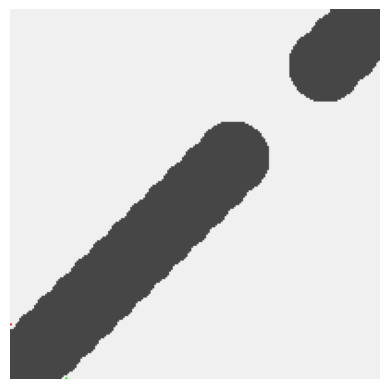

track shape: 200 200
start at coordinates: (30, 0)
end at coordinates: (0, 29)


In [232]:
def place_circle(tab, r, pos: Coor, symbol):
    height = len(tab)
    width = len(tab[0])
    for i in range(height):
        for j in range(width):
            if pos.dist(Coor((i,j))) < r:
                tab[i][j] = symbol
    return tab

N = 100
turn_1 = [[1 for _ in range(N)] for _ in range(N)]
turn_1 = place_circle(turn_1, 110, Coor((0, 0)), 0)
turn_1 = place_circle(turn_1, 80, Coor((0, 0)), 1)
turn_1[N-6][0] = START_CHAR
turn_1[8][N-10] = END_CHAR

N = 200
turn_2 = [[0 for _ in range(N)] for _ in range(N)]
for i in range(13):
    turn_2 = place_circle(turn_2, 20, Coor((N-10*i, 10*i)), 1)
for i in range(4):
    turn_2 = place_circle(turn_2, 20, Coor((10*i, N-10*i)), 1)

turn_2[N-1][30] = START_CHAR
turn_2[N-30][0] = END_CHAR

track_1 = Track(turn_2)
track_1.plot()
print("track shape:", track_1.height, track_1.width)
print("start at coordinates:", track_1.start)
print("end at coordinates:", track_1.end)

### Car class

In [233]:
"""Constant"""
SPEED_MAX = 20

"""Class"""
class Car():
    def __init__(self, coor:Coor):
        self.coor: Coor = Coor((coor.x, coor.y))
        self.speed: float = 0
        self.alpha: float = 0 # The angle of the car according to unitary cicrle
        self.trajectory = [Coor((coor.x, coor.y))]

    def __str__(self):
        return "C[" + str(self.coor) + " " + str(self.speed) + " " + str(self.alpha) + "]"
    

    def accelerate(self, amont=1):
        """Increase speed of the car"""
        acceleration_constant = 1
        self.speed += acceleration_constant*amont
        self.speed = min(SPEED_MAX, self.speed)

    def brake(self, amont=1):
        """Decrease speed of the car (can't drive backward)"""
        brake_constant = 1.5
        self.speed /= (brake_constant*amont)
        if self.speed < 0.01:
            self.speed = 0

    def turn(self, deg):
        """Change the current rotation of the car"""
        self.alpha += deg
        self.alpha = self.alpha % 360

    def get_speed_coor(self):
        cst: float = np.pi / 180
        dx: float = self.speed * np.cos(self.alpha * cst)
        dy: float = self.speed * np.sin(self.alpha * cst)
        return Coor((dx,dy))

    def move(self):
        """Change the coordinate of the care according to its speed and alpha"""
        dx,dy = self.get_speed_coor().get()
        self.coor.x += dx
        self.coor.y += dy
        self.trajectory.append(Coor((self.coor.x, self.coor.y)))

    def dic(self):
        return {"coor":self.coor, "speed":self.speed, "alpha":self.alpha, "trajectory":self.trajectory}

    def plot(self, markersize=8, vector_constant=2, show_trajectory=False, head_width=1):
        """Plot the car and is speed vectors"""
        # Plot car
        x,y = self.coor.get()
        plt.plot(x, y, "o", color='blue', markersize=markersize)
        plt.axis("off")

        # Plot 
        if show_trajectory:
            liste_x = [coor.x for coor in self.trajectory]
            liste_y = [coor.y for coor in self.trajectory]
            plt.plot(liste_x, liste_y, "-o", color="blue", markersize=2)
                 

        # Plot car's directoin
        cst: float = np.pi / 180
        dx: float = np.cos(self.alpha * cst)
        dy: float = np.sin(self.alpha * cst)
        plt.arrow(x, y, dx/10, dy/10, head_width=head_width)
        plt.plot([x, x+ dx*self.speed*vector_constant], [y, y+ dy*self.speed*vector_constant], "-", color="red")


### Gym env

An anction is a $(a,b) \in \{-1,0,1\} \times \{-K,...,0,...,K\}$ where $K$ is a constant that define the maximum angle the car can turn in one movement.
 - -1 is for brake
 - 1 for accelearation
 - 0 for nothing.

In [234]:
class MyEnv(Env):
    def __init__(self, track: Track):
        super(MyEnv, self).__init__()
        self.max_turn = 45
        # Define an action space ranging from 0 to 3
        self.action_space = [i for i in range(4)]

        self.track: Track = track
        self.car: Car = Car(track.start)

        self.canvas = np.array(self.track.color_track)


    def get_state(self):
        """Return actual state of the env"""
        state = np.array(self.track.info_track)
        return state, [val for _,val in self.car.dic().items()]

    def reset(self):
        """Reset the environment"""
        self.car = Car(self.track.start)
        return self.canvas

    def render(self, waiting_time=0.01):
        """Render the environment"""
        self.track.plot(hide=True)
        self.car.plot(show_trajectory=True)
        display.clear_output(wait=True)
        plt.show()
        time.sleep(waiting_time)
        
        
    def step(self, action):
        """Do a step, we suppose that the action is a possible one"""
        is_done = False
        arrival = False
        as_crashed = False

        reward = -1

        previous_dist = self.car.coor.dist(self.track.start)
        if action[0]==-1:
            self.car.brake()
        elif action[0]==1:
            self.car.accelerate()
        self.car.turn(action[1])
        self.car.move()

        new_dist = self.car.coor.dist(self.track.start)
        #reward += 2 *(new_dist - previous_dist)

        if not self.track.is_case_ridable(self.car.coor):
            reward = -100
            as_crashed = True
            is_done = True

        if self.car.coor.dist(self.track.end) <= 0.5:
            reward = 200
            arrival = True
            is_done = True

        return self.canvas, reward, is_done, [arrival, as_crashed]
    
    def random_action(self, p_accel=0.25, p_brake=0.25, p_turn=0.5):
        """Return random possible action according to probability"""
        action = [0,0]
        rd_accel = rd.random()
        if rd_accel <= p_accel:
            action[0] = 1
        elif rd_accel <= p_accel + p_brake:
            action[0] = -1
        
        if rd.random() <= p_turn:
            action[1] = ((-1)**(rd.randint(0,1))) * rd.randint(-self.max_turn, self.max_turn)
        return action

env = MyEnv(track_1)

# Genetic algo

### Explanation for finding K

Let $\varepsilon_2$ be the proportion of population with mutation. We want to mutate more the best people. Let $a = \varepsilon_2 \times$ `LEN_POP`

Then, we want a $K\in \mathbb{N}$ such that $a = \underset{i=0}{\overset{K}{\sum}} i^2 = \frac{1}{6}(2K^3 + 3K^2 +K)$

Then we want $\frac{1}{6}(2K^3 + 3K^2 +K) - a = 0$

Therefore, $K = \frac{1}{2} \left( - \frac{\sqrt[3]{ \sqrt{3}\sqrt{3888a^2-1} -108a}}{3^{2/3}} - \frac{1}{\sqrt[3]{3} \sqrt[3]{\sqrt{3} \sqrt{3888a^2 -1} -108a}} -1 \right)$

In [235]:
def find_K(a):
    res1 = -np.cbrt(np.sqrt(3) * np.sqrt(3888* a**2 - 1) - 108 * a) / (3**(2/3))
    res2 = -1/(np.cbrt(3) * np.cbrt(np.sqrt(3) * np.sqrt(3888* a**2 - 1) - 108 * a))
    return 1/2 * (res1 + res2 -1)

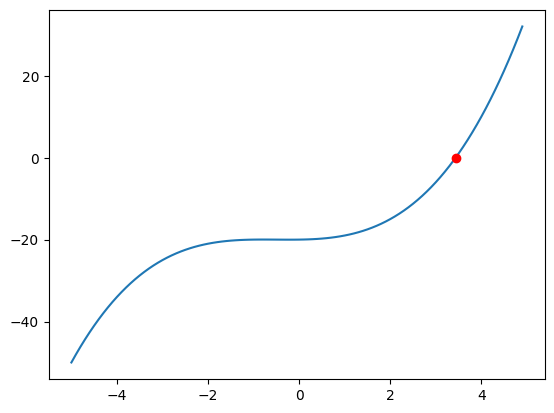

3.4361538052378684 -6.4813647782102635e-09 
the choosen solution for K is: 3


In [236]:
def create_f(a):
    return lambda x: 1/3*x**3 + 1/2*x**2 + 1/6*x - a

LEN_POP = 100
epsilon_2 = 0.2
a = epsilon_2 * LEN_POP
f = create_f(a)

x_liste = [x/10 for x in range(-50,50)]
y_liste = [f(x) for x in x_liste]
plt.plot(x_liste, y_liste, "-")

K=find_K(a)
plt.plot(K, f(K), "o", color="red")
plt.show()
print(K, f(K), "\nthe choosen solution for K is:", int(K))

### Real algo gen

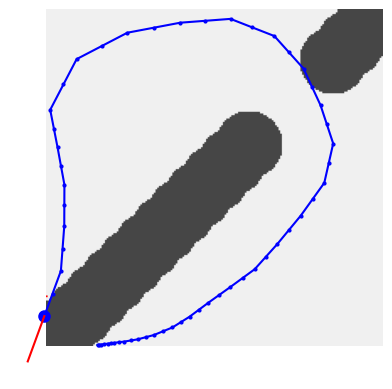

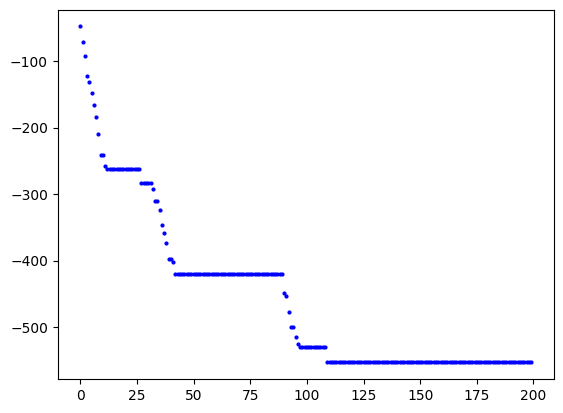

In [238]:
class Indiv():
    def __init__(self, actions=[], sc=None):
        self.actions = [x for x in actions]
        # Not list of actions but list of Time -> action
        self.score = sc

def score(actions, show=False, wt=0.01):
    env.reset()

    sum_diff_dist = 0
    running = True
    sum_reward = 0
    step = 0
    max_step = 100
    sum_dist = 0
    has_crashed = False
    while running:
        x,y = env.car.coor.get()
        prev_pos = Coor((x,y))
        previous_dist = env.car.coor.dist(env.track.start)
        # Simulation
        action = [0, 0]
        if step < len(actions):
            action = actions[step]
        obs, reward, done, infos = env.step(action)
        sum_reward += reward
        env.car.move()

        # Render the game
        if show:
            env.render(waiting_time=wt)

        step += 1
        if (done == True) or (step >=max_step) or (step >= len(actions)) :
            running = False

        var = 0

        if infos[0]:
            var += -2000
        if infos[1]:
            var += 4000
        if step >= max_step:
            var += 1000


        new_dist = env.car.coor.dist(env.track.start)
        sum_diff_dist *= 0.95
        sum_diff_dist += new_dist - previous_dist
        
        if infos[1]:
            has_crashed = 1000
        sum_dist += env.car.coor.dist(prev_pos)
    
    return -sum_dist + has_crashed #+ step/2
    return var + env.car.coor.dist(env.track.end)*4 + step*2 + sum_diff_dist


def rd_action():
    return env.random_action()

def gen_indiv():
    len_actions = rd.randint(1, 10)
    indiv = Indiv([rd_action() for _ in range(len_actions)])
    indiv.score = score(indiv.actions)
    return indiv

    
def gen_pop():
    return [gen_indiv() for i in range(LEN_POP)]

def mutate_indiv(indiv: Indiv):    
    i1 = copy_indiv(indiv)
    x = rd.randint(0, len(i1.actions)-1)
    i1.actions[x] = rd_action()

    i2 = copy_indiv(indiv)
    x = rd.randint(0, len(i1.actions)-1)
    i2.actions.insert(x, rd_action())

    i3 = copy_indiv(indiv)
    x = rd.randint(0, len(i1.actions)-1)
    del i3.actions[x]

    liste_mutations = [i1, i2, i3]
    for indiv in liste_mutations:
        indiv.score = score(indiv.actions)
    return liste_mutations

def cross_over(indiv1: Indiv, indiv2: Indiv):
    co = Indiv()
    for i in range(max(len(indiv1.actions), len(indiv2.actions))):
        possible_acceleration = []
        turn = 0
        for indiv in [indiv1, indiv2]:
            if i < len(indiv.actions):
                possible_acceleration.append(indiv.actions[i][0])
                turn += indiv.actions[i][1]
        turn /= len(possible_acceleration)
        
        action = [rd.choice(possible_acceleration), turn]
        co.actions.append(action)
    co.score = score(co.actions)
    return co

def sort_pop(pop):
    pop.sort( key = lambda x: x.score)

def copy_indiv(indiv: Indiv):
    return Indiv([x for x in indiv.actions], indiv.score)

def select_pop(pop):
    new_pop = []
    pourcentage = 0.25
    k = int( (1 + np.sqrt(1 + 8*pourcentage*LEN_POP)) / 2 ) 

    for i in range( int(0.2*LEN_POP) ):
        new_pop.append(pop[i])
        
    for i in range(k):
        for j in range(i+1, k):
            new_pop.append(cross_over(pop[i], pop[j]))
    

    epsilon_2 = 0.15
    a = epsilon_2 * LEN_POP
    if False:
        K = int(find_K(a))
        for i in range(K):
            for j in range((K-i)**2):
                new_indiv = mutate_indiv(pop[i])
                for id in new_indiv:
                    new_pop.append(id)
    else:
        for i in range(int(a)):
            new_indiv = mutate_indiv(pop[i])
            for id in new_indiv:
                new_pop.append(id)

    while (len(new_pop) < LEN_POP):
        new_pop.append(gen_indiv())

    return new_pop


LEN_POP = 600
def algo_gen():
    NB_GEN = 200
    pop = gen_pop()
    score_liste = []
    for gen in range(NB_GEN):
        sort_pop(pop)
        pop = select_pop(pop)

        if gen % 1 == 0:
            print(gen, end=" ")
        if (gen+1) % 50 == 0:
            print(pop[0].actions)
            score(pop[0].actions, show=True)
        score_liste.append(pop[0].score)
    
    for gen,sc in enumerate(score_liste):
        plt.plot(gen, sc, '-o', color='blue', markersize=2)
    plt.show()
    return pop[0]

        
best = algo_gen()

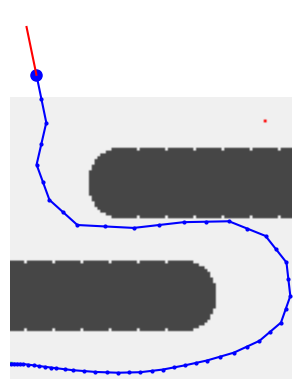

In [184]:
score(best.actions, show=True, wt=0.001)
env.close()